# Credit Risk Scoring

<p align="left">
  <img src="https://botsify.com/blog/wp-content/uploads/2024/09/credit-score-1024x636.jpg" width="600">
</p>


## Scenario:  
Imagine we work in a bank and when banks receives application for a loan we need to make sure that in case of approving the loan, client will be able to pay out the debt.  
We want to minimize the risks before providing with the loan and check the probability of the default.  
  
Machine Learning can help us to calculate the risks. To build such model we need only the data about previously approved loans with clients' information and whether the debt has been fully paid out or client failed to pay money back.

## 1 - Dataset and Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("CreditScoring.csv")
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


We see that the DataFrame contains the following columns:

- **status** — whether the client managed to repay the loan (1) or not (2);

- **seniority** — length of employment in years;

- **home** — type of home ownership: rent (1), ownership (2), and others;

- **time** — planned loan duration (in months);

- **age** — client’s age;

- **marital_status** — single (1), married (2), etc.;

- **records** — whether the client has any previous records: no (1), yes (2).  
  (The dataset description does not clearly specify what kind of records these are.  
  Given the nature of the project, it is reasonable to assume they refer to records in the bank’s database.)

- **job** — type of employment: full-time (1), part-time (2), and others;

- **expenses** — client’s monthly expenses;

- **income** — client’s monthly income;

- **assets** — total value of the client’s assets;

- **debt** — total amount of outstanding debt;

- **amount** — requested loan amount;

- **price** — price of the item the client wants to purchase.


In [3]:
status_values = { 
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)


In [4]:
home_values = { 
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

In [5]:
marital_values = { 
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)


In [6]:
records_values = { 
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

In [7]:
job_values = { 
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


As the next step, let us examine the numerical columns.  
First, we will check the summary statistics for each column: minimum, mean, maximum, and other indicators.


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The reason we see max as 99999999 for *income*, *assets* and *debt* is because those values are NaN values that have been coded this way.

In [10]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Before finishing the dataset preparation let's have a look at our target variable

In [12]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [13]:
# we can remove that one row with unk status
df = df[df.status!='unk']


## 2 - Data Preparation

Now that our dataset has been cleaned, we are almost ready to use it  
to train the model. However, before that, we need to take a few more steps:

- split the dataset into training, validation, and test sets;
- handle missing values;
- apply one-hot encoding for categorical variables;
- create the feature matrix **X** and the target variable **y**.


In [14]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,
     random_state=11)

In [15]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

The outcome we want to predict is **status**. We will use it to train the model, so this is our **y** — the target variable.

Since the goal is to determine whether someone will default on payments, the positive class is **default**. This means that **y = 1** if the client  
does not repay the loan, and **y = 0** otherwise.


In [16]:
y_train = (df_train.status == 'default').values 
y_val = (df_val.status == 'default').values


In [17]:
del df_train['status'] 
del df_val['status']

In [18]:
df_train = df_train.fillna(0) 
df_val = df_val.fillna(0)

To use categorical variables, we need to encode them.  
In one-hot encoding, each value is encoded as **1** if it is present (“hot”) or **0** if it is absent (“cold”).

`DictVectorizer` requires a list of dictionaries, so first we need to convert the DataFrame into this format:


In [19]:
dict_train = df_train.to_dict(orient='records') 
dict_val = df_val.to_dict(orient='records')

In [20]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)


In [21]:
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## 3 - Decision Trees

A decision tree is a data structure that encodes a series of “if–then–else” rules. Each node in the tree contains a condition.  
If the condition is satisfied, we move to the right side of the tree;  otherwise, we move to the left. Eventually, we arrive at a final decision.


### 3.1 - Decision tree clasifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

Model training is implemented by simply calling fit method.

In [23]:
dt = DecisionTreeClassifier() 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


To evaluate the quality of the result, we need to check the predictive performance of the model on the validation set.   
For this purpose, we will use AUC (area under the ROC curve).

Credit risk assessment is a binary classification problem, and for such cases AUC is one of the best metrics.
AUC shows how well the model separates positive examples from  
negative ones.

This metric has a useful interpretation: it describes the probability that a randomly selected positive example (**default**) will receive a higher  
score than a randomly selected negative example (**OK**). This is an important metric for the project: we want risky clients to have higher  
scores than safe ones.


In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
y_pred = dt.predict_proba(X_train)[:, 1] 
roc_auc_score(y_train, y_pred)

1.0

We see the result of 100% Does it  that we can predict the default without any errors?  
Now, let's check the model on validation data.

In [26]:
y_pred = dt.predict_proba(X_val)[:, 1] 
roc_auc_score(y_val, y_pred)

0.6607220701847859

After running the model, we see that the validation AUC is only **65%**.

We have just observed a case of `overfitting`. The tree learned the training data so well that it essentially memorized the outcome for each client.  
However, when we applied it to the validation set, the model made mistakes.

The rules it extracted from the data turned out to be too specific to the training set, so it performed poorly on clients it had not seen during  
training. In such cases, we say that the model cannot generalize.

Overfitting occurs when we have a complex model whose capacity allows it to simply memorize all the training data. If we simplify the model, we can  
make it less powerful and improve its ability to generalize.

There are several ways to control the complexity of a decision tree. One option is to limit its size: we can specify the `max_depth` parameter, which  
controls the maximum number of levels. The more levels a tree has, the more complex rules it can learn.


<p align="left">
  <img src="https://www.statlect.com/images/decision-tree-depth.png" width="600" height="200">
</p>


The default value for `max_depth` is **None** that implies that tree can grow as big as possible.

In [27]:
dt = DecisionTreeClassifier(max_depth=2) 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
from sklearn.tree import export_text
tree_text = export_text(dt, feature_names=dv.feature_names_) 
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- class: True



The condition `records=no > 0.50` means that the client has no records.  
Recall that we use one-hot encoding to represent `records` using two  
features: `records=yes` and `records=no`. For a client who has no records,  
the value of `records=no` is 1, and the value of `records=yes` is 0.  
Therefore, `records=no > 0.50` is true when the value of `records` is **no**.

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

train auc 0.7054989859726213
validation auc 0.6685264343319367


The validation AUC is now sligthly better, however we got another problem the model is too simple.

### 3.2 - Decision tree learning algorithm

To understand how a decision tree extracts patterns from data, let us simplify the task. First, we will use a much smaller dataset  
with a single feature: **assets**.  
  
  The only feature in our dataset is **assets**.  
That is why the condition in a node will be `assets > T`, where **T** is a threshold value that we need to determine. If the condition is true,  
we predict **OK**; if it is false, our prediction will be **default**.



![Decision tree example](images/decision_trees.png)

Now we turn these groups into leaves—decision nodes—by taking the most frequent status in each group and using it as the final decision.  
In our example, **default** is the most frequent outcome in the left group,  
and **OK** is the most frequent in the right group.


#### Impurity

These groups should be as homogeneous as possible. Ideally, each group  
should contain observations from only one class. In this case, we call such groups *pure*.

For example, if we have a group of four clients with outcomes  `[default, default, default, default]`, then it is pure, since it contains  
only clients who defaulted. But the group `[default, default, default, OK]` has impurity: there is one  
client who did not default.

When training a decision tree model, we want to find such a threshold **T** that the impurities in both groups are minimal.

Thus, the algorithm for finding **T** is quite simple:

- try all possible values of **T**;
- for each **T**, split the dataset into left and right groups and measure  
  their impurity;
- choose the **T** that gives the lowest degree of impurity.


To measure impurity, various criteria can be used.  
The simplest one to understand is the **misclassification error**, which shows how many observations in a group do not belong to the majority class.


Let us compute the misclassification error for the split **T = 4000**.

- **For the left group**, the majority class is **default**.  
  There are four data points in total, and one of them does not belong  
  to **default**. The misclassification error is **25%** (1/4).

- **For the right group**, **OK** is the majority class, and there is  
  one **default** among them. Thus, the misclassification error is also  
  **25%** (1/4).

- **To compute the overall impurity of the split**, we can take the  
  average across both groups. In this case, the average impurity is  
  **25%**.


T = 4000 it is not the only value for splitting the assets. We can try the other values: 2000, 3000 and 5000

![Decision](images/T_values.PNG)

- For **T = 2000**, we have **0%** impurity on the left (0/2, all **default**)  
  and **33.3%** impurity on the right (2/6, 2 out of 6 are **default**, the rest are **OK**).  
  The average impurity is **16.6%**.

- For **T = 3000**, there is **0%** impurity on the left and **20%** (1/5)  
  impurity on the right. The average impurity is **10%**.

- For **T = 5000**, there is **50%** (3/6) impurity on the left and **50%** (1/2)  
  impurity on the right. The average impurity is **50%**.


The best average impurity is **10%** at **T = 3000**: we obtained zero errors  
for the left branch and only one error (out of five rows) for the right one.  
Thus, we should choose **3000** as the threshold for our final model.


Now let's add another feature `debt`.  We do the same steps as for the `assets` to find the best threshold that gives lowest level of impurity.  
For `debt` its value is 1000 in this case average impurity is 17%.


![Decision tree](images/T_values_2.PNG)

#### Stopping criteria

When training a decision tree, we can keep splitting the data until all  
groups become pure. This is exactly what happens when we do not impose  
any restrictions on trees in **scikit-learn**. As we have already seen,  
the resulting model becomes too complex, which leads to overfitting.

We addressed this problem using the `max_depth` parameter, limiting the  
size of the tree and preventing it from growing too large.

To decide whether we want to continue splitting the data, we use  
*stopping criteria*—rules that indicate whether we should add another  
split to the tree or stop.

The most common stopping criteria are:

- the group is already pure;
- the tree has reached the maximum depth (controlled by `max_depth`);
- the group is too small to continue splitting (controlled by the  
  `min_samples_leaf` parameter).

By applying these criteria to stop earlier, we simplify our model and,  
as a result, reduce the risk of overfitting.


### 3.3 Parameter tuning for decision tree

In [30]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_pred) 
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.750
  10 -> 0.700
  15 -> 0.672
  20 -> 0.650
None -> 0.665


After running this code, we see that **max_depth = 5** gives the best AUC  
(**76.6%**), followed by **4** and **6**.  
Next let's set min_leaf_size for that matter we will loop over the 3 best max_depth values.

In [31]:
for m in [4, 5, 6]:
    print('depth: %s' % m)
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    print()

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.767
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.756
5 -> 0.759
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.770
100 -> 0.776
200 -> 0.768



After running this code we see that the best AUC is 78.5% with parameters min_sample_leaf = 15 and max_depth = 6

In [32]:
#we will use this combination as it gives the highest AUC
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15) 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Decision Trees are simple and effective models and they become even more effective when multiple trees are combined together.

## 4 -  Random Forest

One model may fail, but if we combine the results of several models into one, the probability  
of an incorrect answer becomes lower. This concept is called **ensemble  learning**, and a combination of models is called an **ensemble**.

For this to work, the models must be different. If we train the same decision tree model ten times, it will predict exactly the same result,  
making the entire effort pointless.

The simplest way to obtain different models is to train each tree on a different subset of features.


For example, suppose we have three features: **assets**, **debts**, and  
**price**. We can train three models:

- the first uses **assets** and **debts**;
- the second uses **debts** and **price**;
- the last uses **assets** and **price**.

With this approach, we obtain different trees, each of which makes its  
own decisions. But when we combine their predictions, the errors are  averaged out, and overall we achieve better predictive performance.

This method of combining multiple decision trees into an ensemble is  called a **random forest**. To train a random forest, we can do the  
following:

- train **N** independent decision tree models;
- for each model, select a random subset of features and use only them  
  for training;
- during prediction, combine the outputs of the **N** models into one.


### 4.1 - Training a random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

The first thing we have to set during the model training is the number of trees `n_estimators` parameter is used for that.

In [34]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)


,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
y_pred = rf.predict_proba(X_val)[:, 1] 
roc_auc_score(y_val, y_pred)

0.7721688745731515

Each time we retrain the model, the score changes: it varies from  **77% to 80%**.

The reason for this is randomization: when training a tree, we randomly select a subset of objects. To make the results consistent, we need to  
fix the initial value of the random number generator by assigning a specific value to the `random_state` parameter.


In [36]:
rf = RandomForestClassifier(n_estimators=10, random_state=3) 
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_pred = rf.predict_proba(X_val)[:, 1] 
roc_auc_score(y_val, y_pred)

0.7811145285897654

Number of trees in ensemble is important parameter, affecting the model performance. Usually, model with more trees work better than the one with fewer.  
On the other side adding too many trees is not always useful.

In [38]:
aucs = []
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)


10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


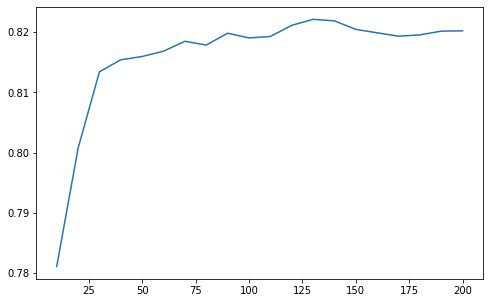

In [39]:
plt.figure(figsize=(8,5))
plt.plot(range(10, 201, 10), aucs)

Performance increases rapidly for the first **25–30 trees**, after which the growth slows down. After about **130 trees**, adding more trees no  
longer affects performance, which remains at approximately **82%**.

The number of trees is not the only parameter that we can adjust to improve performance.


### 4.2 - Parameter tuning for random forest

A random forest ensemble consists of multiple decision trees, so the most  
important parameters that we need to tune for a random forest are the same:

- `max_depth`;
- `min_leaf_size`.


In [40]:
all_aucs = {}
for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.788
20 -> 0.798
30 -> 0.800
40 -> 0.800
50 -> 0.800
60 -> 0.801
70 -> 0.802
80 -> 0.803
90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

depth: 10
10 -> 0.791
20 -> 0.808
30 -> 0.812
40 -> 0.818
50 -> 0.817
60 -> 0.819
70 -> 0.820
80 -> 0.820
90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

depth: 20
10 -> 0.776
20 -> 0.803
30 -> 0.813
40 -> 0.817
50 -> 0.815
60 -> 0.813
70 -> 0.814
80 -> 0.815
90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



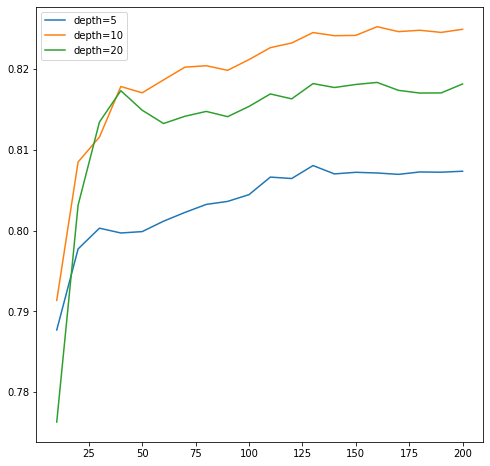

In [41]:
num_trees = list(range(10, 201, 10))
plt.figure(figsize=(8,8))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.legend()

When max_depth = 10 AUC is above 82%. Let's tune min_samples_leaf with the best max_depth parameter

In [42]:
all_aucs = {}
for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10,
                                    min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.811
30 -> 0.823
50 -> 0.823
70 -> 0.822
90 -> 0.823
110 -> 0.823
130 -> 0.824
150 -> 0.825
170 -> 0.825
190 -> 0.825

min_samples_leaf: 5
10 -> 0.813
30 -> 0.818
50 -> 0.821
70 -> 0.822
90 -> 0.822
110 -> 0.825
130 -> 0.825
150 -> 0.825
170 -> 0.825
190 -> 0.826

min_samples_leaf: 10
10 -> 0.810
30 -> 0.822
50 -> 0.822
70 -> 0.819
90 -> 0.820
110 -> 0.820
130 -> 0.821
150 -> 0.820
170 -> 0.820
190 -> 0.820



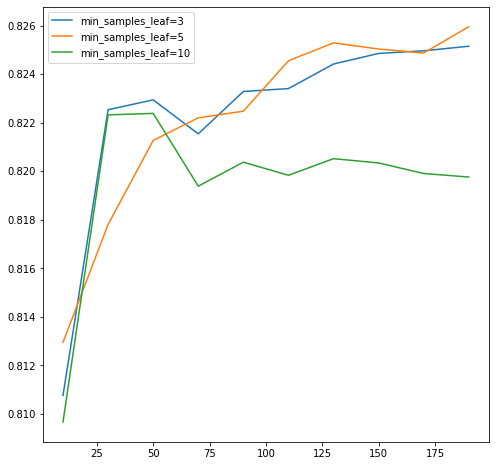

In [43]:
num_trees = list(range(10, 201, 20))
plt.figure(figsize=(8,8))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()

We see that AUC looks slightly better for smaller values of  
`min_samples_leaf`, with the best value being **5**.

Thus, the best parameters for the random forest in our task are:

- `max_depth = 10`;
- `min_samples_leaf = 5`.

We achieved the best AUC with **200 trees**, so we should set `n_estimators = 200`.

Let us train the final model:


In [44]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10,
     min_samples_leaf=5, random_state=1)

Random forest is not the only way to combine several decision trees together, there is another approach called **Gradient Boosting**

## 5 - Gradient Boosting

In a random forest, each tree is independent: it is trained on its own subset of features. After the individual trees are trained, we combine  
all their decisions to obtain the final result.

However, this is not the only way to combine multiple models into a single ensemble. As an alternative, we can train models **sequentially**—each  
new model tries to correct the mistakes of the previous one:

- train the first model;
- look at the errors it makes;
- train another model that corrects these errors;
- look at the errors again and repeat this process over and over.

This way of combining models is called **boosting**.  
**Gradient boosting** is a special variant of this approach that works  
particularly well with decision trees.


### 5.1 - XGBoost:  Extreme gradient boosting

In [45]:
import xgboost as xgb

Before we can train an **XGBoost** model, we need to wrap our data in a **DMatrix** — a special data structure designed for efficient split finding.


In [46]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)

When creating a **DMatrix** instance, we pass three parameters:

- `X_train` — the feature matrix;
- `y_train` — the target variable;
- `feature_names` — the names of the features in `X_train`.


In [47]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [48]:
xgb_params = { 
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic', 
    'nthread': 8,
    'seed': 1,
    'verbosity': 0
}

For us, the most important parameter at this point is **`objective`**: it defines the learning task. We are solving a binary classification problem,  
which is why we need to choose **`binary:logistic`**. We will look at the other parameters a bit later.

To train an **XGBoost** model, we use the `train` function. Let us start with ten trees


In [49]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

To evaluate it, we need to make predictions using the validation dataset.  
For this, we use the `predict` method with the validation data wrapped in a **DMatrix**:


In [50]:
y_pred = model.predict(dval)


In [51]:
y_pred[:10]

array([0.05866029, 0.06297418, 0.07957753, 0.12453752, 0.05471457,
       0.10543569, 0.04962284, 0.34493914, 0.62430215, 0.02429806],
      dtype=float32)

In [52]:
roc_auc_score(y_val, y_pred)

0.8118506454190986

As a result, we obtain **81.2%**. This is quite a good outcome, but it is still worse than our best random forest model (**82.5%**).

Training an XGBoost model becomes easier when we can see how its performance changes as we increase the number of trees.

### 5.2 - Model performance monitoring

To get an idea of how AUC changes as the number of trees increases, we can use a **watchlist** — a built-in XGBoost feature for monitoring model  
performance.

A watchlist is a Python list of tuples. Each tuple contains a **DMatrix** and its name.


In [53]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = { 
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic', 
    'eval_metric': 'auc', 
    'nthread': 8,
    'seed': 1,
    'silent': 1}

In [54]:
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100, 
                  evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86653	val-auc:0.77999
[10]	train-auc:0.95512	val-auc:0.81115
[20]	train-auc:0.97648	val-auc:0.81877
[30]	train-auc:0.98844	val-auc:0.81613
[40]	train-auc:0.99393	val-auc:0.81407
[50]	train-auc:0.99723	val-auc:0.81276
[60]	train-auc:0.99861	val-auc:0.81244
[70]	train-auc:0.99962	val-auc:0.81243
[80]	train-auc:0.99989	val-auc:0.81359
[90]	train-auc:0.99998	val-auc:0.81038
[99]	train-auc:0.99999	val-auc:0.80838


In [55]:
%%capture output

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=5)

In [56]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [57]:
tree, aucs_train, aucs_val = parse_xgb_output(output)

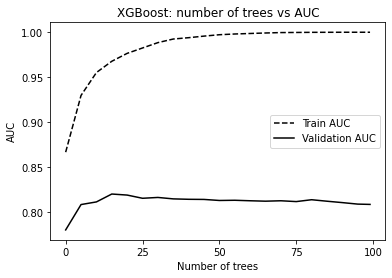

In [58]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_train, color='black', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

This behavior is expected: during training, each subsequent model tries  
to correct the errors of the previous step, so the score improves every  time.

However, this is not the case on the validation set. At first, the score increases, and then it starts to decrease. This is the effect of  
overfitting: the model becomes more and more complex until it simply memorizes the entire training set. As a result, prediction for clients  
outside the training set becomes useless, and the validation score  reflects this.

We obtain the best AUC at the **30th iteration** (**81.7%**), but it is not much different from the result obtained at the **10th iteration**  
(**81.5%**).


### 5.3 - Parameter tuning for XGBoost

In [104]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [105]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.81877
(0.81877, 20)


We are most interested in the first three parameters. They control the  
training process:

- `eta` — the learning rate. Decision trees and random forests do not have  
  this parameter. We will look at it later in this section when tuning  
  the model;

- `max_depth` — the maximum allowed depth of each tree; the same as  
  `max_depth` in `DecisionTreeClassifier` from scikit-learn;

- `min_child_weight` — the minimum number of observations in each group;  
  equivalent to `min_leaf_size` in `DecisionTreeClassifier` from  
  scikit-learn.

Below is a description of the other parameters:

- `objective` — the type of task being solved. For classification, this is  
  `binary:logistic`;

- `eval_metric` — the metric we use for evaluation. For this project, it  
  is **AUC**;

- `nthread` — the number of threads used for training. XGBoost parallelizes  
  very well, so set this parameter according to the number of CPU cores on  
  your machine;

- `seed` — the initial value for the random number generator; we need to  
  set it to ensure reproducibility of results;

This is not a complete list of parameters, but only the main ones.


#### Learning rate

In boosting, each tree tries to correct the errors of the previous iterations. The learning rate determines the weight of this correction.  
If a large value of `eta` is set, the correction strongly outweighs the previous predictions. On the other hand, if the value is small, only a  
small part of this correction is used.

In practice, this means the following:

- if `eta` is too large, the model starts to overfit quite early and does  
  not fully realize its potential;

- if `eta` is too small, we have to train too many trees before the model  
  can achieve a decent result.

The default value of **0.3** works well for large datasets, but for smaller  
ones like ours, it is worth trying smaller values such as **0.1** or even **0.05**.


In [106]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [107]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.82851
(0.82851, 90)


In [108]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [109]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.829
(0.829, 110)


In [110]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [111]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.82645
(0.82645, 499)


When `eta` is **0.3**, we reach the best AUC quite quickly, but then overfitting begins. After the **30th iteration**, performance on the  
validation set starts to decline.

When `eta` is **0.1**, AUC grows more slowly but reaches its maximum at a higher value. With a lower learning rate, reaching the peak requires more  
trees, but it allows us to achieve better performance.

For comparison, we can also try other values of `eta`:
- for **0.05**, the best AUC is **82.2%** (after **120 iterations**);
- for **0.01**, the best AUC is **82.1%** (after **500 iterations**).


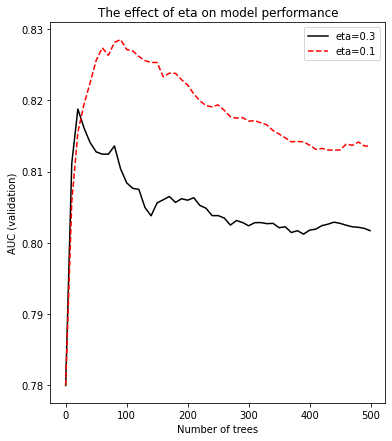

In [112]:
plt.figure(figsize=(6, 7))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='red', linestyle='--', label='eta=0.1')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')


plt.show()

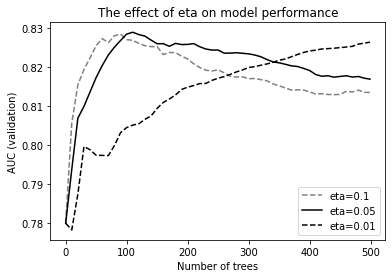

In [113]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_01, color='grey', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='black', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='black', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')


plt.show()

The model requires a larger number of trees when the `eta` parameter is small.


#### max_depth Parameter

In [118]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [119]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.83406
(0.83406, 160)


AUC when Depth equals 3 is `83.4`%

In [120]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [121]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val))
print(max(zip(aucs_val_depth10, tree)))

0.81993
(0.80768, 290)


AUC when Depth equals 10 is `81.9`%

In [122]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [123]:
tree, _, aucs_val_depth4 = parse_xgb_output(output)
print(max(aucs_val_depth4))
print(max(zip(aucs_val_depth4, tree)))

0.82887
(0.82887, 140)


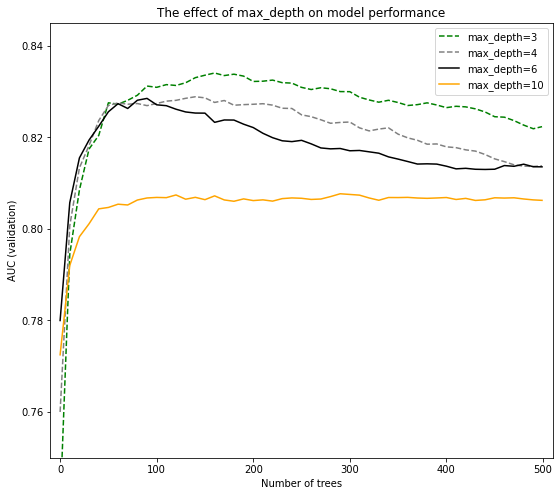

In [127]:
plt.figure(figsize=(9, 8))

plt.plot(tree, aucs_val_depth3, color='green', linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth4, color='grey', linestyle='dashed', label='max_depth=4')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, color='orange', linestyle='solid', label='max_depth=10')

plt.ylim(0.75, 0.845)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')


plt.show()

We see that the best value for max depth parameter is 3 